In [1]:
import os
import pyarrow as pa
import pyarrow.parquet as parquet
from astropy.io import fits
import pandas as pd
import sys 
sys.path.insert(0, '/home/bekah/gPhoton2')
from gPhoton.io.mast import download_data
import matplotlib.pyplot as plt 

from photutils.background import Background2D, MedianBackground
from astropy.stats import SigmaClip
import numpy as np

from quickbin import bin2d

In [2]:
def centile_clip(image, centiles=(1, 99)):
    """
    simple clipping function that clips values above and below a given
    percentile range
    """
    finite = np.ma.masked_invalid(image)
    bounds = np.percentile(finite[~finite.mask].data, centiles)
    result = np.ma.clip(finite, *bounds)
    
    if isinstance(image, np.ma.MaskedArray):
        
        return result
    
    return result.data

In [3]:
e4112_nosub = fits.open("/media/bekah/BekahA/background_test/e14112_FUV_threshold_lessthan1Flat.fits")
cnt_image = e4112_nosub[1].data

In [4]:
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(cnt_image,
                       (50, 50),
                       filter_size=(3, 3),
                       bkg_estimator=bkg_estimator,
                       sigma_clip=sigma_clip)

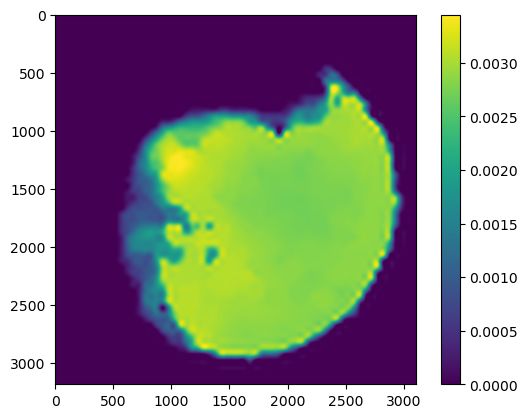

In [5]:
plt.imshow(bkg.background)
plt.colorbar()

In [6]:
eclipse = '14112'

# photon table would already exist in gphoton2 
photons = parquet.read_table(f"/home/bekah/gPhoton2/test_data/e{eclipse}/e{eclipse}-fd-b00.parquet", 
                             columns=['ra','dec','col','row','q','flags','detrad','t']).to_pandas()

# want photons that are on detector, no flags, has aspect soln 
photons = photons[(photons['detrad'] < 600)]
photons = photons.dropna(subset=['ra', 'dec'])
photons = photons[(photons['flags'] < 1)]

# binning 
ra = bin2d(photons['col'],photons['row'],photons['ra'],n_bins=800,op=('count', 'std'))
dec = bin2d(photons['col'],photons['row'],photons['dec'],n_bins=800,op=('std'))
q_m =  bin2d(photons['col'],photons['row'],photons['q'],n_bins=800,op=('min', 'max'))

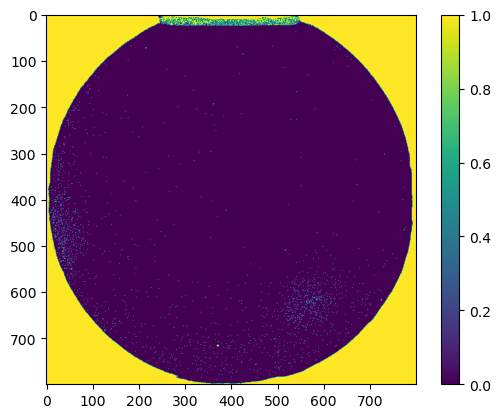

In [11]:
plt.imshow(ra['count']<2)
plt.colorbar()